In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from gnninterpreter import *

In [3]:
import random
from collections import defaultdict, namedtuple
from itertools import combinations_with_replacement

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from tqdm.auto import tqdm, trange

import torch
from torch import nn
import torch_geometric as pyg
from torchmetrics import F1Score

# Motif

In [4]:
motif = MotifDataset(seed=12345)
k_fold = 10
train_data = motif[len(motif)//k_fold:]
val_data = motif[:len(motif)//k_fold]
train_loader = pyg.loader.DataLoader(train_data, batch_size=128, shuffle=True)
val_loader = pyg.loader.DataLoader(val_data, batch_size=128, shuffle=False)

In [5]:
motif.describe()

{'mean_n': 57.068510970427546,
 'mean_m': 77.36094007458156,
 'std_n': 25.639083000023053,
 'std_m': 36.160709236674464}

# Train Model

In [11]:
model = GCNClassifier(hidden_channels=64,
                      node_features=len(motif.NODE_CLS),
                      num_classes=len(motif.GRAPH_CLS),
                      num_layers=3)

In [12]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [13]:
def train():
    model.train()
    losses = []
    for batch in tqdm(train_loader, position=1, leave=False, disable=True):
        model.zero_grad()  # Clear gradients.
        out = model(batch)  # Perform a single forward pass.
        loss = criterion(out['logits'], batch.y)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        losses.append(loss.item())
    return np.mean(losses)

@torch.no_grad()
def test(loader):
    f1 = F1Score(task="multiclass", num_classes=len(motif.GRAPH_CLS), average=None)
    model.eval()
    for batch in tqdm(loader, position=1, leave=False, disable=True):
        f1(model(batch)['logits'], batch.y)
    return dict(zip(motif.GRAPH_CLS.values(), f1.compute().tolist()))

@torch.no_grad()
def gt_score():
    batch = pyg.data.Batch.from_data_list([motif.motifs[1]])
    neg, pos = model(batch).mean(dim=0).numpy()
    return neg, pos

In [27]:
for epoch in trange(1, position=0, leave=True, disable=True):
    train_loss = train()
    train_acc = test(train_loader)
    test_acc = test(val_loader)
    # neg, pos = gt_score()
    print(
        f'Epoch: {epoch:03d}, '
        f'Train Loss: {train_loss:.4f}, '
        f'Train Acc: {train_acc}, '
        f'Test Acc: {test_acc}, '
        # f'GT Pos Score: {pos:.4f}, '
        # f'GT Neg Score: {neg:.4f}, '
    )

Epoch: 000, Train Loss: 0.0162, Train Acc: {'partial': 0.9925030469894409, 'house': 0.9964841604232788, 'house_x': 0.9990205764770508, 'comp_4': 0.99700528383255, 'comp_5': 1.0}, Test Acc: {'partial': 0.9819819927215576, 'house': 0.9912663698196411, 'house_x': 0.9978308081626892, 'comp_4': 0.9937106966972351, 'comp_5': 1.0}, 


In [14]:
# torch.save(model.state_dict(), 'motif_gnn_64x3.pt')
model.load_state_dict(torch.load('motif_gnn_64x3.pt'))

<All keys matched successfully>

In [15]:
test(train_loader)

{'partial': 0.9925030469894409,
 'house': 0.9964841604232788,
 'house_x': 0.9990205764770508,
 'comp_4': 0.99700528383255,
 'comp_5': 1.0}

In [16]:
test(val_loader)

{'partial': 0.9819819927215576,
 'house': 0.9912663698196411,
 'house_x': 0.9978308081626892,
 'comp_4': 0.9937106966972351,
 'comp_5': 1.0}

# Generate Average Embedding

In [17]:
embeds = [[] for _ in range(len(motif.GRAPH_CLS))]
with torch.no_grad():
    for data in tqdm(motif):
        embeds[data.y.item()].append(model.eval()(pyg.data.Batch.from_data_list([data]))["embeds"].numpy())
mean_embeds = [torch.tensor(np.concatenate(e).mean(axis=0)) for e in embeds]

  0%|          | 0/11531 [00:00<?, ?it/s]

In [18]:
trainer = {}
sampler = {}

# 1

In [19]:
classes = 1
sampler[classes] = s = GraphSampler(max_nodes=20,
                                    num_node_cls=len(motif.NODE_CLS),
                                    temperature=0.15,
                                    learn_node_feat=True)

criterion = nn.Sequential(
    WeightedCriterion([
        # dict(key="logits", criterion=ClassScoreCriterion(class_idx=0), mode="maximize", weight=0.5),
        dict(key="logits", criterion=ClassScoreCriterion(class_idx=1), mode="maximize", weight=1),
        # dict(key="logits", criterion=ClassScoreCriterion(class_idx=2), mode="maximize", weight=-0.5),
        # dict(key="logits", criterion=ClassScoreCriterion(class_idx=3), mode="maximize", weight=-0.5),
        # dict(key="logits", criterion=CrossEntropyBoundaryCriterion(class_a=0, class_b=1), weight=1),
        # dict(key="logits", criterion=MeanSquareBoundaryCriterion(class_a=0, class_b=1), weight=1),
        # dict(key="logits", criterion=DynamicBalancingCriterion(classes=classes), weight=5),
        # dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[classes[0]]), weight=10),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[1]), weight=1),
    ]),
    NormPenalty(lambda: s.omega, order=1, weight=1), # L1 penalty on omega, encourage uncertainty
    NormPenalty(lambda: s.omega, order=2, weight=1), # L2 penalty on omega, avoid extreme probabilities
    NormPenalty(lambda: s.xi, order=1, weight=0), # L1 penalty on xi
    NormPenalty(lambda: s.xi, order=2, weight=0), # L2 penalty on xi
    budget := BudgetPenalty(lambda: s.theta, budget=10, order=2, beta=0.5, weight=1), # Budget penalty on theta, encourage sparsity
    CrossEntropyPenalty(lambda: s.theta, weight=0), # Element-wise entropy penalty on theta, encourage discreteness
    KLDivergencePenalty(lambda: tuple(s.theta_pairs), binary=True, weight=0), # Pair-wise cross entropy on E, encourage connectivity
)
optimizer = torch.optim.SGD(s.parameters(), lr=1)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=1)

# construct graph sampler trainer
trainer[classes] = Trainer(sampler=s,
                  discriminator=model,
                  criterion=criterion,
                  optimizer=optimizer,
                  scheduler=scheduler,
                  dataset=motif,
                  k_samples=16)

In [20]:
def penalty_cond(out, trainer, boundary_cls=classes):
    return out["probs"][0, classes].item() > 0.9


In [21]:
def break_cond(out, trainer, boundary_cls=classes):
    return all([
        penalty_cond(out, trainer, boundary_cls),
        trainer.sampler.expected_m < 15
    ])

In [22]:
trainer[1].train(2000, dynamic_penalty=budget, penalty_cond=penalty_cond, break_cond=break_cond)

  0%|          | 0/2000 [00:00<?, ?it/s]

True

n=14 m=15
logits=[8.010212898254395, 12.983661651611328, -16.276866912841797, -20.305919647216797, -21.189367294311523]
probs=[0.006871697027236223, 0.9931282997131348, 1.9467907104095405e-13, 3.4635693903326166e-15, 1.4316876982176877e-15]


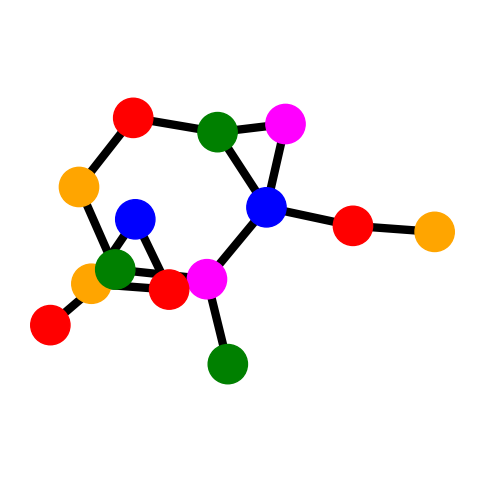

In [23]:
G = trainer[classes].evaluate(threshold=0.5, show=True)
plt.show()

# 2

In [45]:
classes = 2
sampler[classes] = s = GraphSampler(max_nodes=20,
                                    num_node_cls=len(motif.NODE_CLS),
                                    temperature=0.15,
                                    learn_node_feat=True)

criterion = nn.Sequential(
    WeightedCriterion([
        dict(key="logits", criterion=ClassScoreCriterion(class_idx=classes), mode="maximize", weight=1),
        # dict(key="logits", criterion=CrossEntropyBoundaryCriterion(class_a=0, class_b=1), weight=1),
        # dict(key="logits", criterion=MeanSquareBoundaryCriterion(class_a=0, class_b=1), weight=1),
        # dict(key="logits", criterion=DynamicBalancingCriterion(classes=[classes]), weight=1),
        # dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[classes[0]]), weight=10),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[classes]), weight=5),
    ]),
    NormPenalty(lambda: s.omega, order=1, weight=1), # L1 penalty on omega, encourage uncertainty
    NormPenalty(lambda: s.omega, order=2, weight=1), # L2 penalty on omega, avoid extreme probabilities
    NormPenalty(lambda: s.xi, order=1, weight=0), # L1 penalty on xi
    NormPenalty(lambda: s.xi, order=2, weight=0), # L2 penalty on xi
    budget := BudgetPenalty(lambda: s.theta, budget=10, order=2, beta=0.5, weight=1), # Budget penalty on theta, encourage sparsity
    CrossEntropyPenalty(lambda: s.theta, weight=0), # Element-wise entropy penalty on theta, encourage discreteness
    KLDivergencePenalty(lambda: tuple(s.theta_pairs), binary=True, weight=0), # Pair-wise cross entropy on E, encourage connectivity
)
optimizer = torch.optim.SGD(s.parameters(), lr=1)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=1)

# construct graph sampler trainer
trainer[classes] = Trainer(sampler=s,
                           discriminator=model,
                           criterion=criterion,
                           optimizer=optimizer,
                           scheduler=scheduler,
                           dataset=motif,
                           k_samples=16)

In [46]:
def penalty_cond(out, trainer, boundary_cls=classes):
    return out["probs"][0, classes].item() > 0.9


In [47]:
def break_cond(out, trainer, boundary_cls=classes):
    return all([
        penalty_cond(out, trainer, boundary_cls),
        trainer.sampler.expected_m < 15
    ])

In [48]:
trainer[2].train(2000, dynamic_penalty=budget, penalty_cond=penalty_cond, break_cond=break_cond)

  0%|          | 0/2000 [00:00<?, ?it/s]

True

n=11 m=14
logits=[10.12785816192627, -28.11570930480957, 18.187055587768555, -9.166486740112305, -14.25048542022705]
probs=[0.00031608054996468127, 7.777274096052175e-21, 0.9996839761734009, 1.3193810193684596e-12, 8.173672276393183e-15]


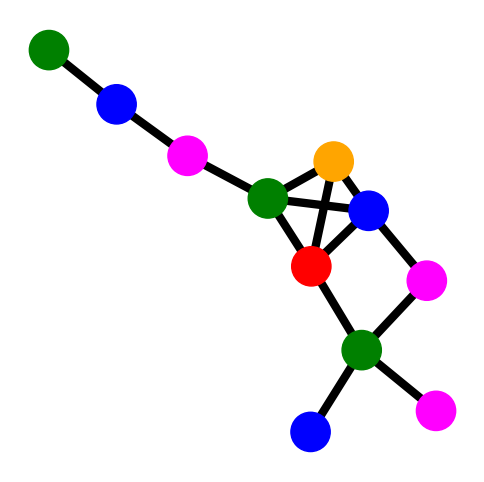

In [49]:
trainer[2].evaluate(threshold=0.5, show=True)

n=20 m=40
logits=[-10.088390350341797, 9.188565254211426, 10.531853675842285, -22.014690399169922]
probs=[8.79087080907226e-10, 0.20696978271007538, 0.7930301427841187, 5.8144089620326776e-15]


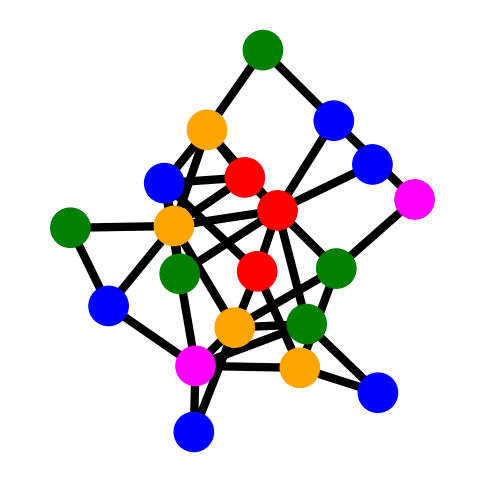

In [131]:
trainer[1, 2].evaluate(bernoulli=True, show=True)

# 3

In [51]:
classes = 3
sampler[classes] = s = GraphSampler(max_nodes=20,
                                    num_node_cls=len(motif.NODE_CLS),
                                    temperature=0.15,
                                    learn_node_feat=True)

criterion = nn.Sequential(
    WeightedCriterion([
        dict(key="logits", criterion=ClassScoreCriterion(class_idx=classes), mode="maximize", weight=1),
        # dict(key="logits", criterion=CrossEntropyBoundaryCriterion(class_a=0, class_b=1), weight=1),
        # dict(key="logits", criterion=MeanSquareBoundaryCriterion(class_a=0, class_b=1), weight=1),
        # dict(key="logits", criterion=DynamicBalancingCriterion(classes=[classes]), weight=1),
        # dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[classes[0]]), weight=10),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[classes]), weight=5),
    ]),
    NormPenalty(lambda: s.omega, order=1, weight=1), # L1 penalty on omega, encourage uncertainty
    NormPenalty(lambda: s.omega, order=2, weight=1), # L2 penalty on omega, avoid extreme probabilities
    NormPenalty(lambda: s.xi, order=1, weight=0), # L1 penalty on xi
    NormPenalty(lambda: s.xi, order=2, weight=0), # L2 penalty on xi
    budget := BudgetPenalty(lambda: s.theta, budget=10, order=2, beta=0.5, weight=1), # Budget penalty on theta, encourage sparsity
    CrossEntropyPenalty(lambda: s.theta, weight=0), # Element-wise entropy penalty on theta, encourage discreteness
    KLDivergencePenalty(lambda: tuple(s.theta_pairs), binary=True, weight=0), # Pair-wise cross entropy on E, encourage connectivity
)
optimizer = torch.optim.SGD(s.parameters(), lr=1)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=1)

# construct graph sampler trainer
trainer[classes] = Trainer(sampler=s,
                           discriminator=model,
                           criterion=criterion,
                           optimizer=optimizer,
                           scheduler=scheduler,
                           dataset=motif,
                           k_samples=16)

In [52]:
def penalty_cond(out, trainer, boundary_cls=classes):
    return out["probs"][0, classes].item() > 0.9
    
def break_cond(out, trainer, boundary_cls=classes):
    return all([
        penalty_cond(out, trainer, boundary_cls),
        trainer.sampler.expected_m < 15
    ])

In [54]:
trainer[3].train(2000, dynamic_penalty=budget, penalty_cond=penalty_cond, break_cond=break_cond)

  0%|          | 0/2000 [00:00<?, ?it/s]

True

n=13 m=15
logits=[16.50334358215332, -41.19040298461914, -16.474313735961914, 21.241636276245117, -41.53955841064453]
probs=[0.008677618578076363, 7.6265058757010564e-28, 4.134147454633056e-17, 0.99132239818573, 5.378828148874545e-28]


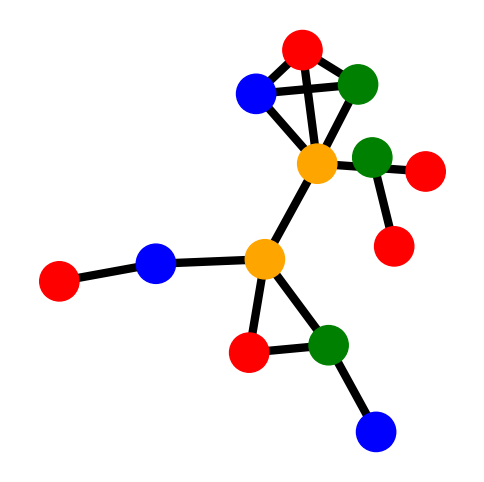

In [55]:
trainer[3].evaluate(threshold=0.5, show=True)

n=13 m=15
logits=[16.50334358215332, -41.19040298461914, -16.474313735961914, 21.241636276245117, -41.53955841064453]
probs=[0.008677618578076363, 7.6265058757010564e-28, 4.134147454633056e-17, 0.99132239818573, 5.378828148874545e-28]


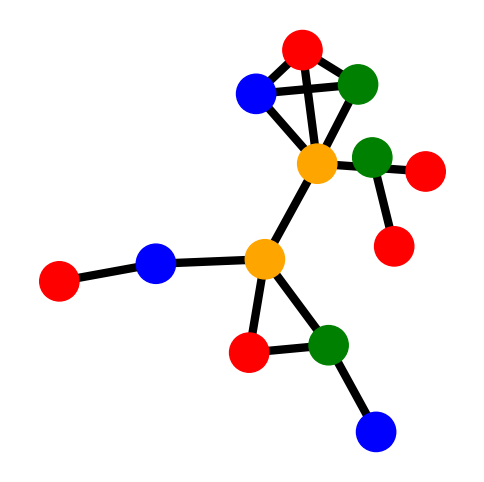

In [56]:
trainer[3].evaluate(bernoulli=True, show=True)

# 4

In [68]:
classes = 4
sampler[classes] = s = GraphSampler(max_nodes=20,
                                    num_node_cls=len(motif.NODE_CLS),
                                    temperature=0.15,
                                    learn_node_feat=True)

criterion = nn.Sequential(
    WeightedCriterion([
        dict(key="logits", criterion=ClassScoreCriterion(class_idx=classes), mode="maximize", weight=1),
        # dict(key="logits", criterion=CrossEntropyBoundaryCriterion(class_a=0, class_b=1), weight=1),
        # dict(key="logits", criterion=MeanSquareBoundaryCriterion(class_a=0, class_b=1), weight=1),
        # dict(key="logits", criterion=DynamicBalancingCriterion(classes=[classes]), weight=1),
        # dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[classes[0]]), weight=10),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[classes]), weight=5),
    ]),
    NormPenalty(lambda: s.omega, order=1, weight=1), # L1 penalty on omega, encourage uncertainty
    NormPenalty(lambda: s.omega, order=2, weight=1), # L2 penalty on omega, avoid extreme probabilities
    NormPenalty(lambda: s.xi, order=1, weight=0), # L1 penalty on xi
    NormPenalty(lambda: s.xi, order=2, weight=0), # L2 penalty on xi
    budget := BudgetPenalty(lambda: s.theta, budget=10, order=2, beta=0.5, weight=1), # Budget penalty on theta, encourage sparsity
    CrossEntropyPenalty(lambda: s.theta, weight=0), # Element-wise entropy penalty on theta, encourage discreteness
    KLDivergencePenalty(lambda: tuple(s.theta_pairs), binary=True, weight=0), # Pair-wise cross entropy on E, encourage connectivity
)
optimizer = torch.optim.SGD(s.parameters(), lr=1)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=1)

# construct graph sampler trainer
trainer[classes] = Trainer(sampler=s,
                           discriminator=model,
                           criterion=criterion,
                           optimizer=optimizer,
                           scheduler=scheduler,
                           dataset=motif,
                           k_samples=16)

In [69]:
def penalty_cond(out, trainer, boundary_cls=classes):
    return out["probs"][0, classes].item() > 0.9
    
def break_cond(out, trainer, boundary_cls=classes):
    return all([
        penalty_cond(out, trainer, boundary_cls),
        trainer.sampler.expected_m < 15
    ])

In [70]:
trainer[4].train(5000, dynamic_penalty=budget, penalty_cond=penalty_cond, break_cond=break_cond)

  0%|          | 0/5000 [00:00<?, ?it/s]

True

n=10 m=14
logits=[20.852563858032227, -40.37002944946289, -12.6128568649292, -44.95913314819336, 29.786319732666016]
probs=[0.00013184444105718285, 3.3995969008549225e-31, 3.8566825601311526e-19, 3.454657408895744e-33, 0.9998681545257568]


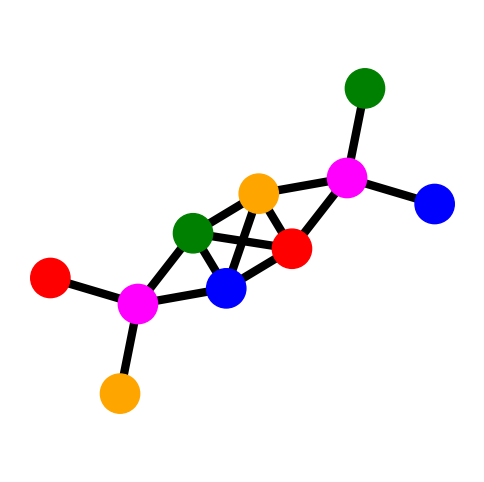

In [71]:
trainer[4].evaluate(threshold=0.5, show=True)

n=10 m=14
logits=[20.852563858032227, -40.37002944946289, -12.6128568649292, -44.95913314819336, 29.786319732666016]
probs=[0.00013184444105718285, 3.3995969008549225e-31, 3.8566825601311526e-19, 3.454657408895744e-33, 0.9998681545257568]


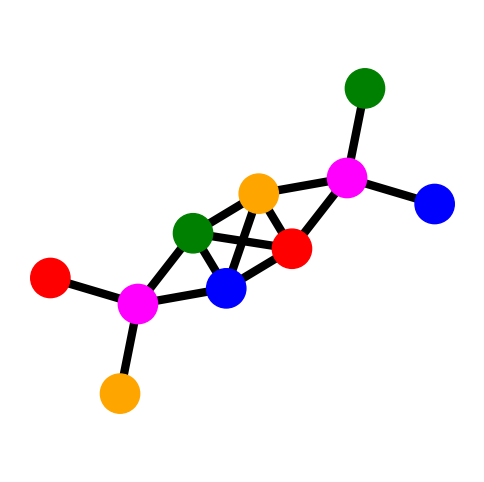

In [72]:
trainer[4].evaluate(bernoulli=True, show=True)